In [4]:
import sys
import os
sys.path.append('../..')
sys.path

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
import tensorflow as tf
tf.__version__, tf.config.get_visible_devices()

('2.18.0',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [6]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
ds = datasets.Dataset("JNUB")
task = ds['fault']
sets = task[0]
task.meta

Dataset JNUB already downloaded and extracted
Remember to cite the original publisher dataset:
	@article{li2013sequential,
	  title={Sequential fuzzy diagnosis method for motor roller bearing in variable operating conditions based on vibration analysis},
	  author={Li, Ke and Ping, Xueliang and Wang, Huaqing and Chen, Peng and Cao, Yi},
	  journal={Sensors},
	  volume={13},
	  number={6},
	  pages={8013--8041},
	  year={2013},
	  publisher={Molecular Diversity Preservation International (MDPI)}
	}
	
You can download the dataset manually from:  https://github.com/ClarkGableWang/JNU-Bearing-Dataset

** If you find this tool useful, please cite our SoftwareX paper.



Reading : 100%|██████████| 12/12 [00:01<00:00, 11.37it/s]
INFO:root:Read in 1.2261850833892822 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: vibration,speed,fault,unit
INFO:root:Train shape: (3003000, 4)
INFO:root:Val shape: (3003000, 4)
INFO:root:Test shape: (3003000, 4)


{'identifier': ['unit'],
 'split_by': ['speed'],
 'features': ['vibration'],
 'target': 'fault',
 'target_labels': ['health state',
  'inner ring',
  'outer ring',
  'rolling element'],
 'type': 'classification:multiclass',
 'nature': 'time-series',
 'target_distribution': [0.5,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 'min_ts_len': 500500,
 'num_units': 12,
 'min_units_per_class': 3}

In [17]:
from phm_framework.data import prepare_data

X_train, M_train, Y_train = prepare_data(sets['train'], 'vibration', subsignal_length=128, signal_max_length=500500)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'vibration', subsignal_length=128, signal_max_length=500500)



INFO:root:Meta-attributes extracted in 22.945910930633545 seconds
INFO:root:Meta-attributes extracted in 22.909806966781616 seconds


In [18]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/tmp/ipykernel_31708/1648391898.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


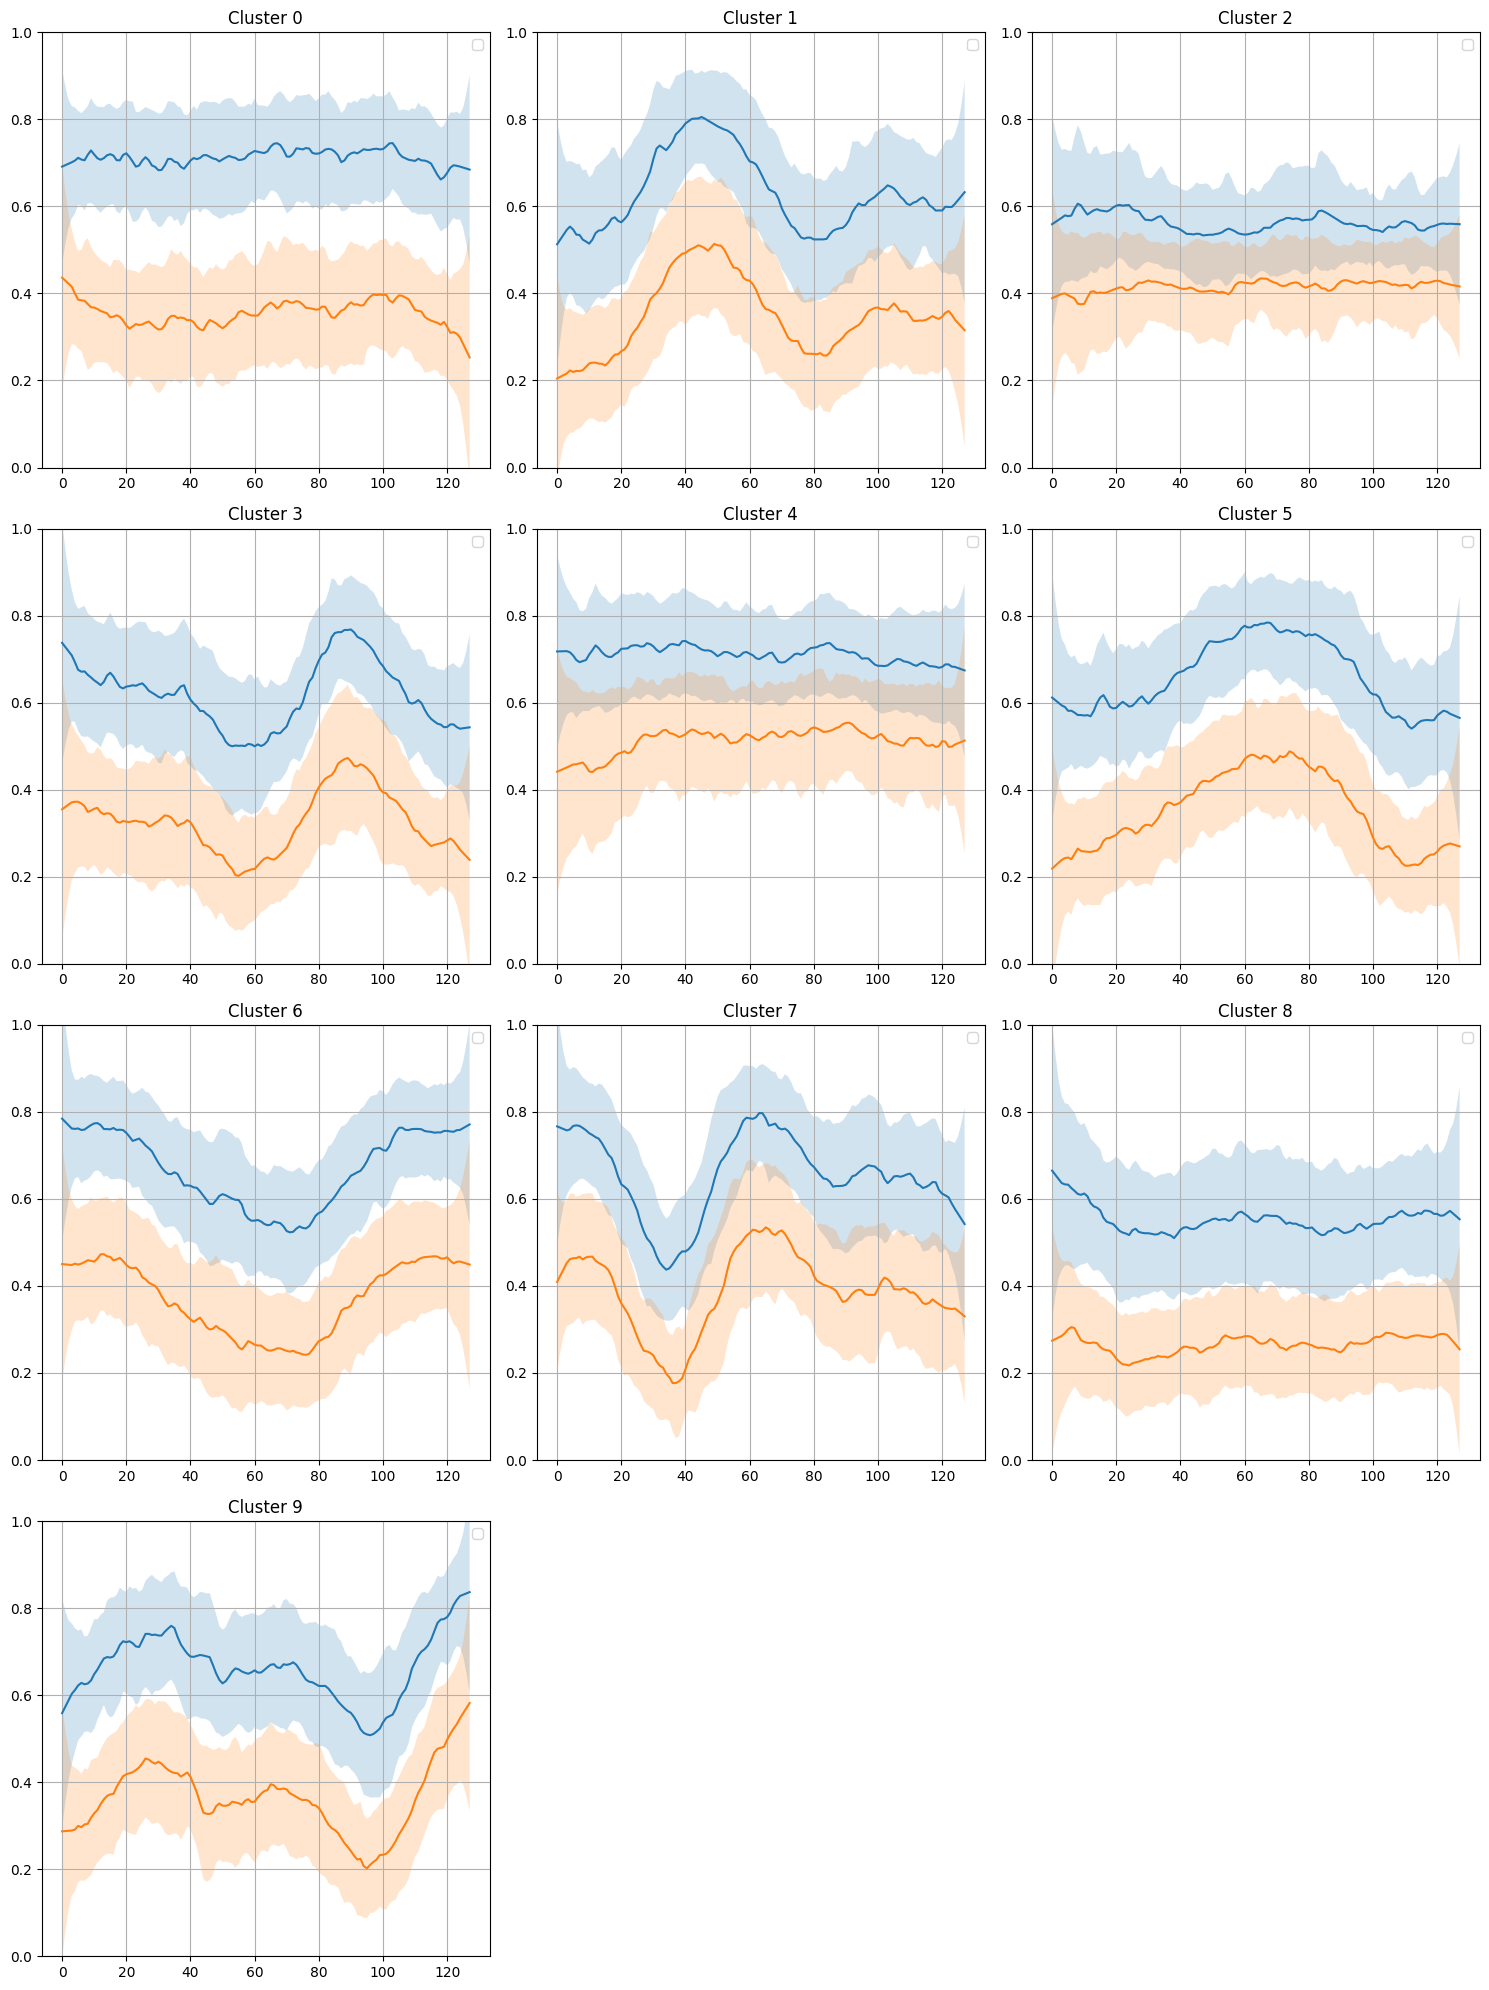

In [19]:
from phm_framework.xai import plot

plot.plot_clusters(None, None, centroids, stds, 10)

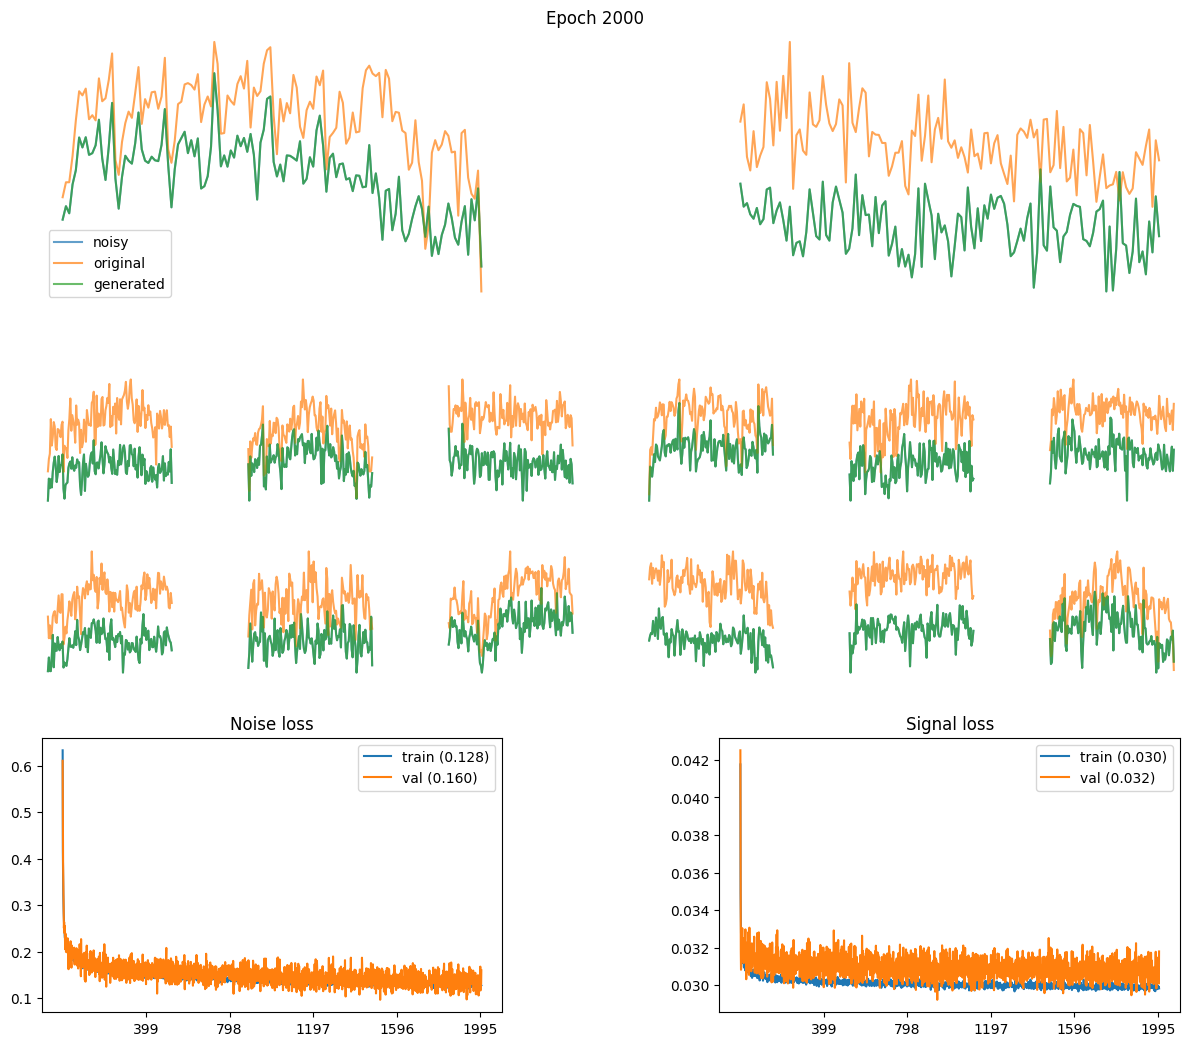

100/100 - 7s - 71ms/step - noise_loss: 0.1279 - signal_loss: 0.0298 - val_noise_loss: 0.1602 - val_signal_loss: 0.0318


In [20]:
from phm_framework.nets import dpm 
reload(dpm)

meta_att = [f"att{i}" for i in range(M.shape[1])]

model = dpm.DiffusionModel(X.shape[1],
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)



model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=tf.keras.losses.MeanAbsoluteError(),
    run_eagerly=False
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_signal_loss', patience=8)

plot_idxs = np.random.uniform(0, X.shape[0], 14).astype(int)

def plotting(*args, **kwargs):
    return model.plot_images(np.expand_dims(X[plot_idxs], axis=-1), 
                             np.moveaxis(E[plot_idxs], -1, -2),
                             np.expand_dims(M[plot_idxs], axis=-1), 
                           *args, **kwargs)

pi = tf.keras.callbacks.LambdaCallback(on_epoch_end=plotting),
                

model.fit(
    (np.expand_dims(X, axis=-1), 
     np.moveaxis(E, -1, -2), 
     np.expand_dims(M, axis=-1)),
    epochs=2000,
    batch_size=32,
    steps_per_epoch=100,
    verbose=2,
    validation_data=(np.expand_dims(X, axis=-1)[:128], 
                     np.moveaxis(E[:128], -1, -2), 
                     np.expand_dims(M, axis=-1)[:128]),
    callbacks=[pi]
)



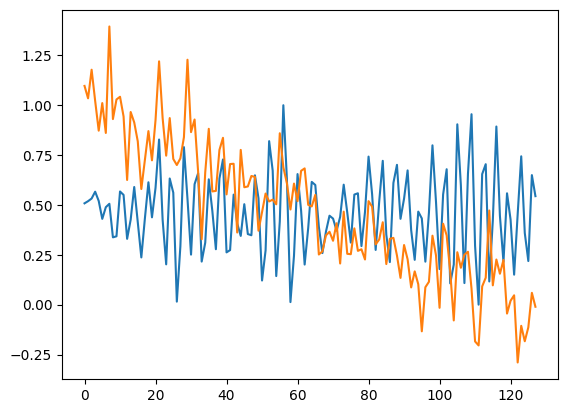

In [280]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

s = X_train[100]
f = generate_meta(s, centroids)

f[-5] = -0.05

sn = synthetic.generate_synthetic_from_dpm(s, model, centroids, forced_features=f)


plt.plot(s)
plt.plot(sn)